**Predicting BitCoin Price using Recurrent Networks*** 

I will be using the the Bitcoin historical data.

In [1]:
# First step, import libraries and then dataset
import numpy as np 
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt
import os 

#print(os.listdir('../input/bitcoin-historical-data'))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# Import the dataset and encode the date
path_to_data = "../input/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv" 
df = pd.read_csv(path_to_data) 
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()
#print(Real_Price.shape)

In [3]:
# We will predict the prices for 50 days, so splitting the data accordingly
prediction_days = 50
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]

In [4]:
# Some preprocessing, like normalizing the values, reshaping, etc. The data is a time series data, so the output to every instance is the next instance. 
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

**Part 1: Using Long short-term memory (LSTM) network **

In [5]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, CuDNNGRU, GRU, CuDNNLSTM,SimpleRNN

# Initialising 
regressor = Sequential()

# Adding the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling using Adam optimizaer and MSE loss
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the LSTM to the Training set
regressor.fit(X_train, y_train, batch_size = 15, epochs = 50)

Epoch 1/50
1414/1414 [==============================] - 3s 2ms/sample - loss: 0.1010
Epoch 2/50
1414/1414 [==============================] - 1s 366us/sample - loss: 0.0461
Epoch 3/50
1414/1414 [==============================] - 1s 357us/sample - loss: 0.0356
Epoch 4/50
1414/1414 [==============================] - 1s 363us/sample - loss: 0.0340
Epoch 5/50
1414/1414 [==============================] - 0s 349us/sample - loss: 0.0330
Epoch 6/50
1414/1414 [==============================] - 1s 363us/sample - loss: 0.0321
Epoch 7/50
1414/1414 [==============================] - 0s 344us/sample - loss: 0.0310
Epoch 8/50
1414/1414 [==============================] - 1s 374us/sample - loss: 0.0299
Epoch 9/50
1414/1414 [==============================] - 0s 353us/sample - loss: 0.0287
Epoch 10/50
1414/1414 [==============================] - 1s 367us/sample - loss: 0.0274
Epoch 11/50
1414/1414 [==============================] - 0s 343us/sample - loss: 0.0259
Epoch 12/50
1414/1414 [====================

In [6]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
er1 = np.mean((predicted_BTC_price-test_set)**2)
print("Mean Square Error (MSE) using LSTM:", er1)

Mean Square Error (MSE) using LSTM: 284947.22289240826


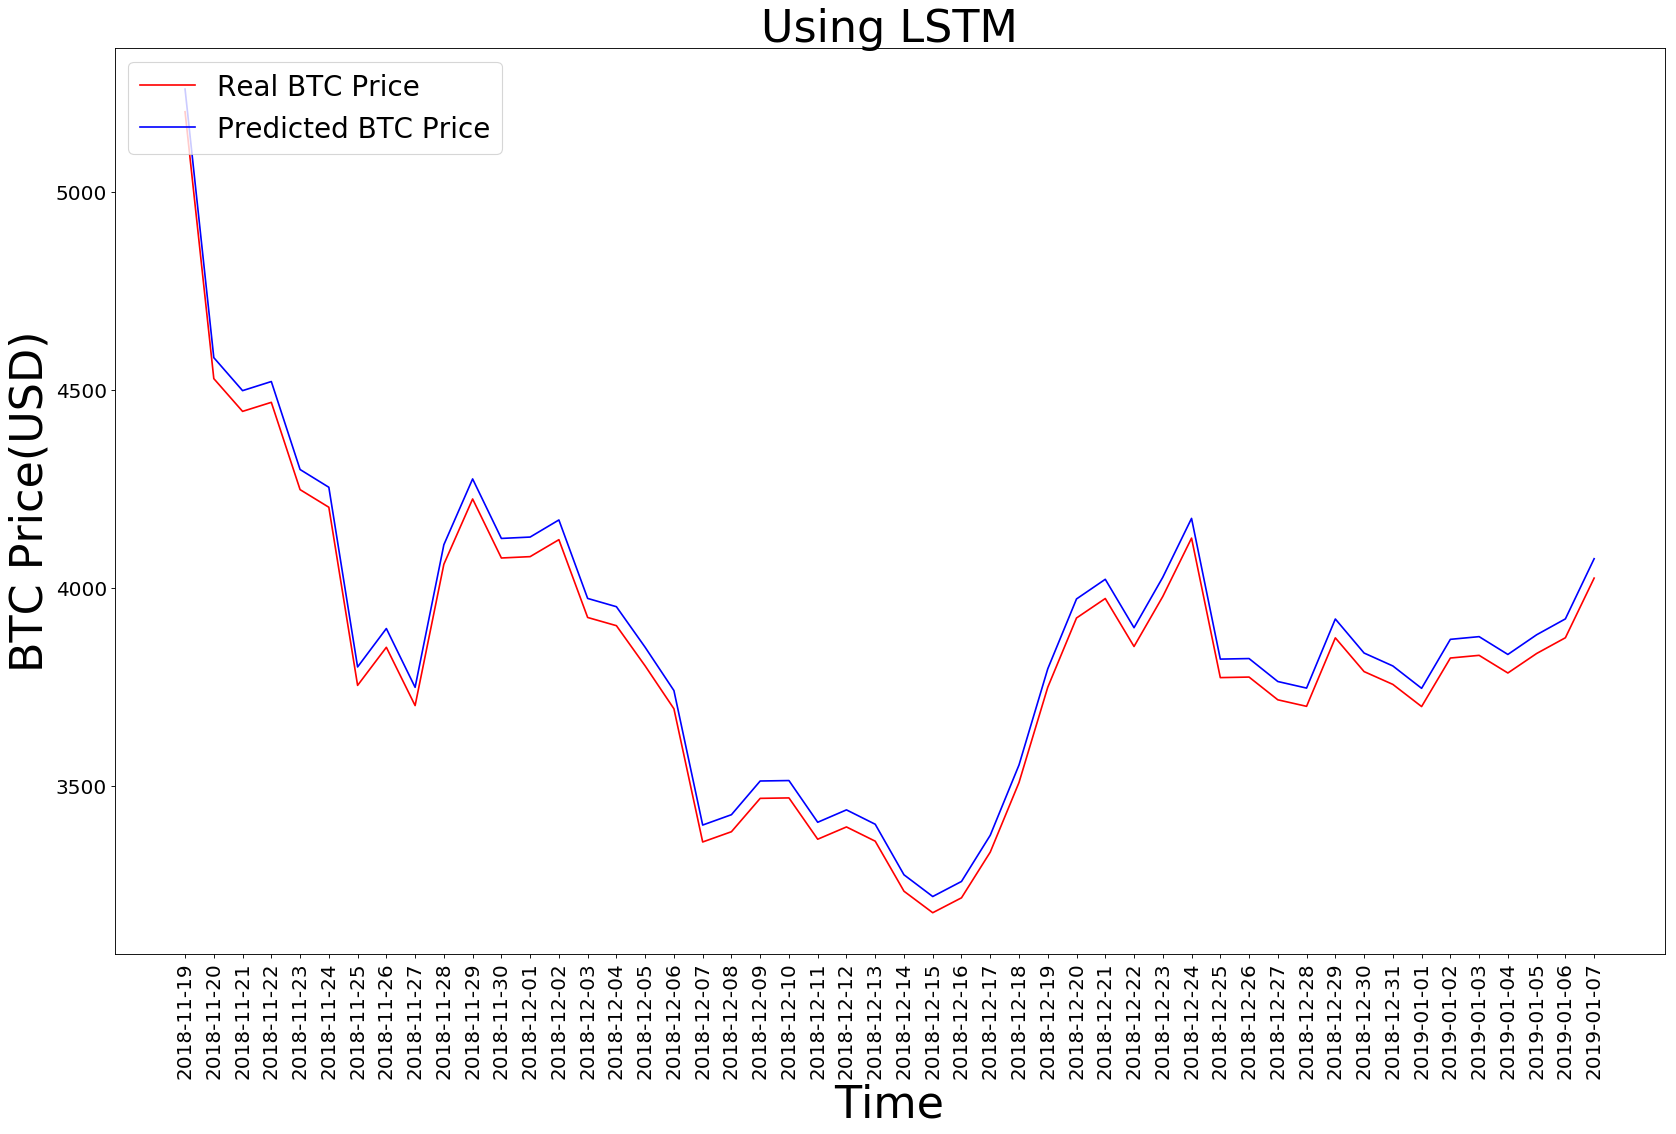

In [7]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('Using LSTM', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()


**Part 2: Using Gated Recurrent Units (GRU) **

In [8]:
# Initialising
regressor2 = Sequential()

# Adding the GRU layer
regressor2.add(GRU(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor2.add(Dense(units = 1))

# Compiling the GRU using Adam optimizer and MSE loss
regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the GRU to the Training set
regressor2.fit(X_train, y_train, batch_size = 15, epochs = 50)

Epoch 1/50
1414/1414 [==============================] - 1s 806us/sample - loss: 0.0566
Epoch 2/50
1414/1414 [==============================] - 0s 337us/sample - loss: 0.0340
Epoch 3/50
1414/1414 [==============================] - 0s 318us/sample - loss: 0.0316
Epoch 4/50
1414/1414 [==============================] - 0s 324us/sample - loss: 0.0301
Epoch 5/50
1414/1414 [==============================] - 0s 343us/sample - loss: 0.0282
Epoch 6/50
1414/1414 [==============================] - 0s 321us/sample - loss: 0.0262
Epoch 7/50
1414/1414 [==============================] - 0s 331us/sample - loss: 0.0237
Epoch 8/50
1414/1414 [==============================] - 0s 325us/sample - loss: 0.0209
Epoch 9/50
1414/1414 [==============================] - 0s 333us/sample - loss: 0.0179
Epoch 10/50
1414/1414 [==============================] - 0s 323us/sample - loss: 0.0149
Epoch 11/50
1414/1414 [==============================] - 0s 337us/sample - loss: 0.0119
Epoch 12/50
1414/1414 [==================

In [9]:
# Prediction from the trained GRU network
predicted_BTC_price = regressor2.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
er2 = np.mean((predicted_BTC_price-test_set)**2)
print("Mean Square Error (MSE) using GRU:", er2)

Mean Square Error (MSE) using GRU: 287069.8788940507


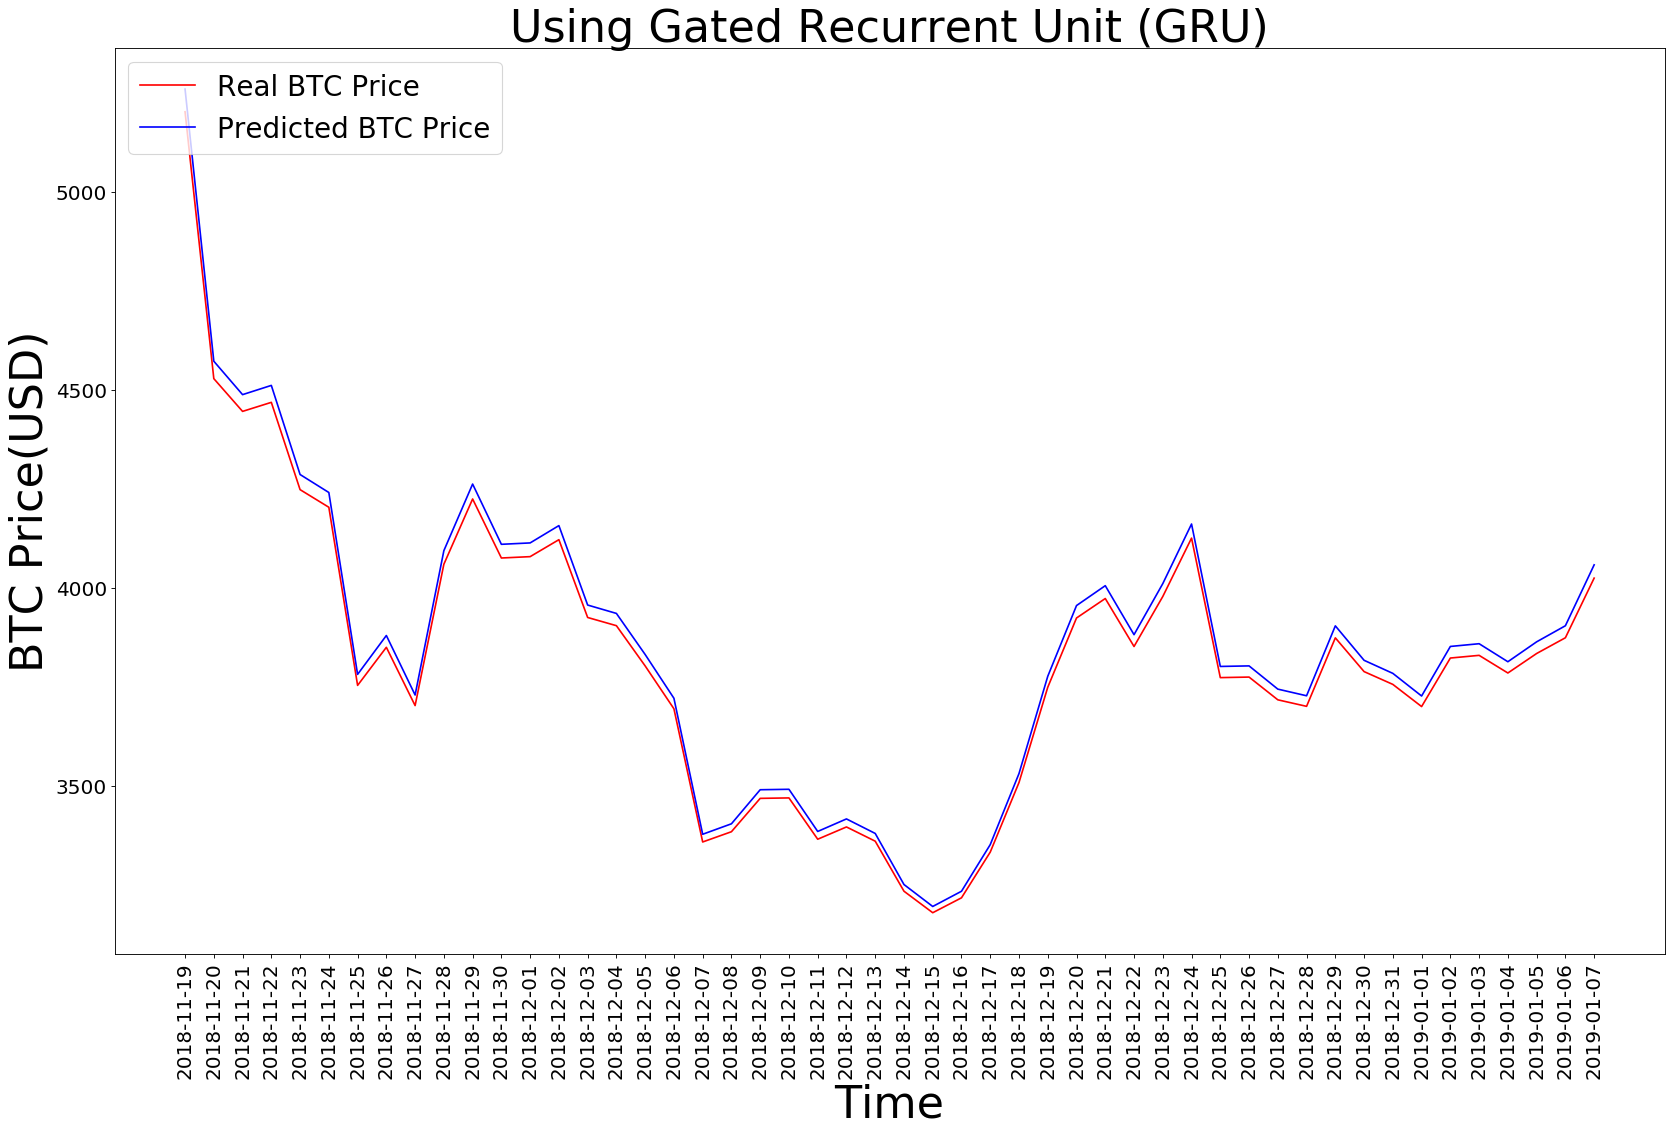

In [10]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('Using Gated Recurrent Unit (GRU)', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

**Part 3: Using a different (and faster) GRU implementation backed by CuDNN**

In [11]:
# Initialising
regressor3 = Sequential()

# Adding the hidden layer
regressor3.add(CuDNNGRU(units = 4,  kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', input_shape = (None, 1)))

# Adding the output layer
regressor3.add(Dense(units = 1))

# Compiling with Adam and MSE loss
regressor3.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Training
regressor3.fit(X_train, y_train, batch_size = 15, epochs = 50)

Epoch 1/50
1414/1414 [==============================] - 3s 2ms/sample - loss: 0.0253
Epoch 2/50
1414/1414 [==============================] - 0s 256us/sample - loss: 0.0132
Epoch 3/50
1414/1414 [==============================] - 0s 257us/sample - loss: 0.0064
Epoch 4/50
1414/1414 [==============================] - 0s 244us/sample - loss: 0.0025
Epoch 5/50
1414/1414 [==============================] - 0s 268us/sample - loss: 7.8352e-04
Epoch 6/50
1414/1414 [==============================] - 0s 247us/sample - loss: 2.7736e-04
Epoch 7/50
1414/1414 [==============================] - 0s 245us/sample - loss: 1.7403e-04
Epoch 8/50
1414/1414 [==============================] - 0s 263us/sample - loss: 1.5770e-04
Epoch 9/50
1414/1414 [==============================] - 0s 246us/sample - loss: 1.5613e-04
Epoch 10/50
1414/1414 [==============================] - 0s 241us/sample - loss: 1.5644e-04
Epoch 11/50
1414/1414 [==============================] - 0s 271us/sample - loss: 1.5659e-04
Epoch 12/50
141

In [12]:
# Prediction 
predicted_BTC_price = regressor3.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
er3 = np.mean((predicted_BTC_price-test_set)**2)
print("Mean Square Error (MSE) using CuDNNGRU:", er3)

Mean Square Error (MSE) using CuDNNGRU: 285598.478758182


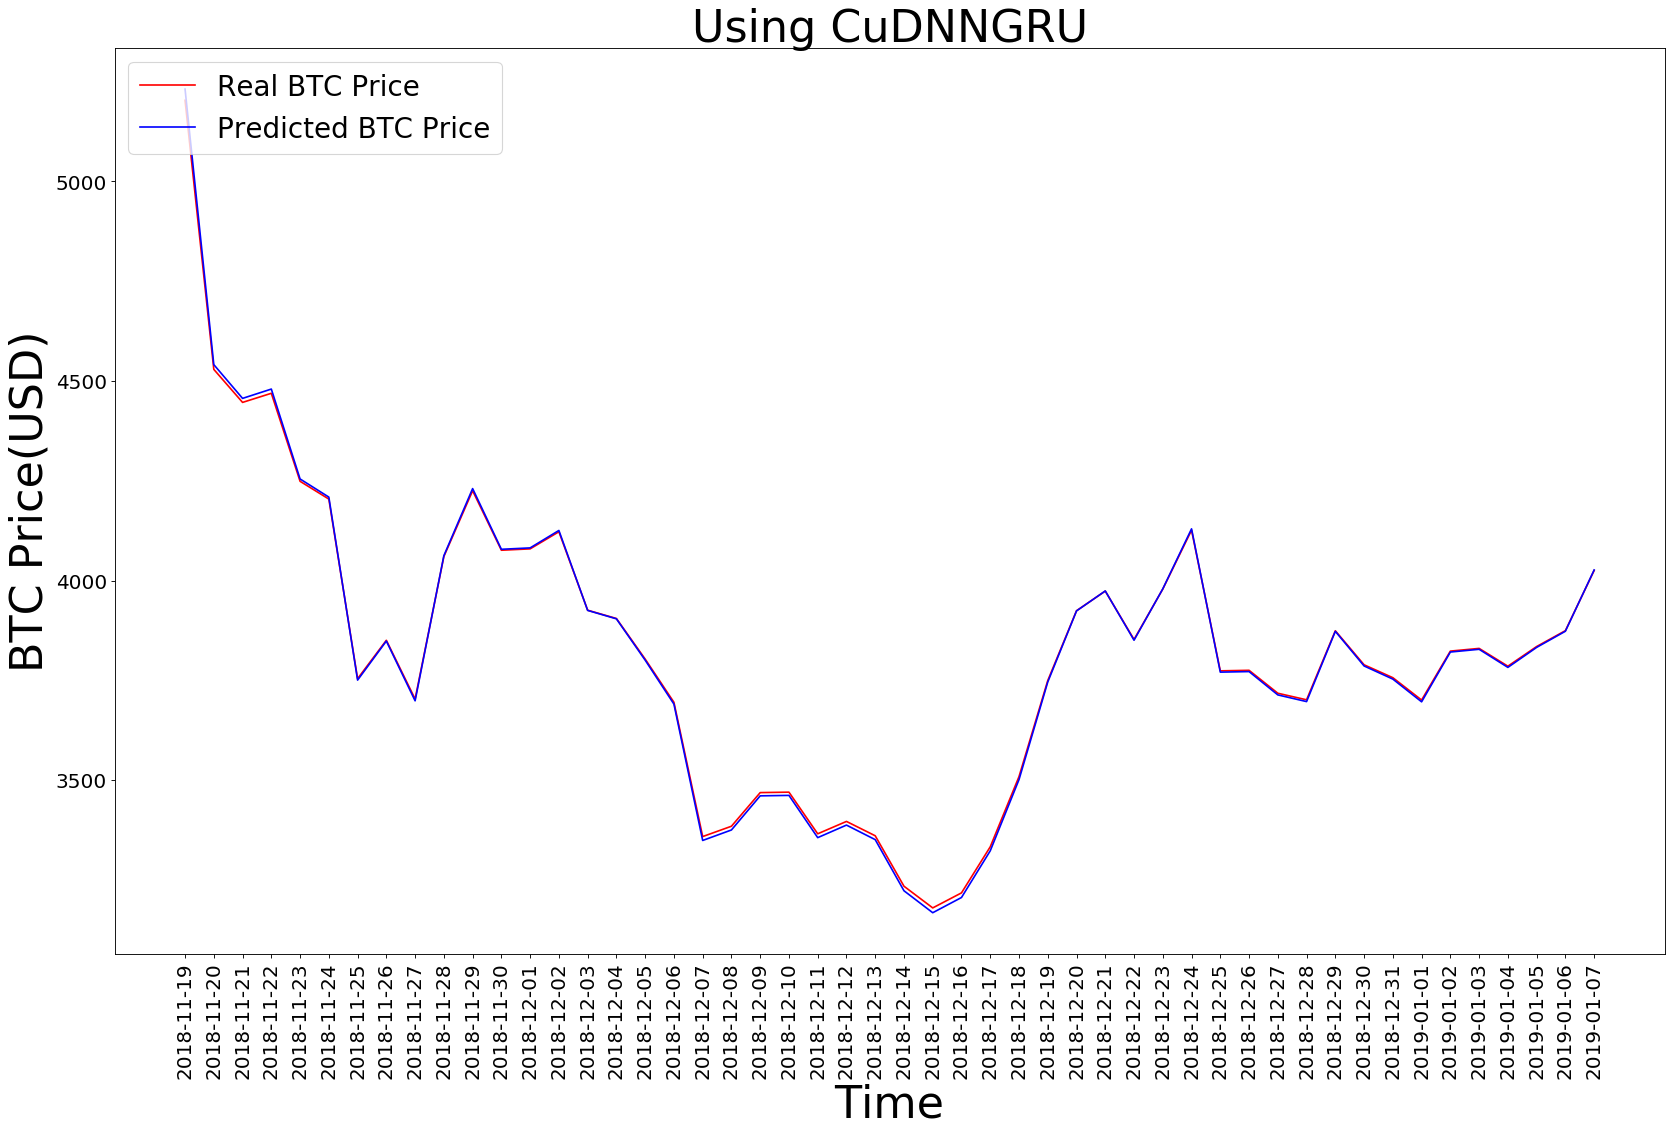

In [13]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('Using CuDNNGRU', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

**Part 4: Using Simple RNN**

In [14]:
# Initialising the RNN
from tensorflow.keras.layers import LSTM, CuDNNGRU, GRU, CuDNNLSTM,SimpleRNN
regressor4 = Sequential()

# Adding the simple RNN
regressor4.add(SimpleRNN(units = 4, activation='sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor4.add(Dense(units = 1))

# Compiling the RNN
regressor4.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor4.fit(X_train, y_train, batch_size = 15, epochs = 50)

Epoch 1/50
1414/1414 [==============================] - 1s 605us/sample - loss: 0.6108
Epoch 2/50
1414/1414 [==============================] - 0s 234us/sample - loss: 0.2859
Epoch 3/50
1414/1414 [==============================] - 0s 241us/sample - loss: 0.1331
Epoch 4/50
1414/1414 [==============================] - 0s 251us/sample - loss: 0.0681
Epoch 5/50
1414/1414 [==============================] - 0s 238us/sample - loss: 0.0438
Epoch 6/50
1414/1414 [==============================] - 0s 240us/sample - loss: 0.0360
Epoch 7/50
1414/1414 [==============================] - 0s 254us/sample - loss: 0.0337
Epoch 8/50
1414/1414 [==============================] - 0s 237us/sample - loss: 0.0328
Epoch 9/50
1414/1414 [==============================] - 0s 231us/sample - loss: 0.0322
Epoch 10/50
1414/1414 [==============================] - 0s 261us/sample - loss: 0.0316
Epoch 11/50
1414/1414 [==============================] - 0s 235us/sample - loss: 0.0309
Epoch 12/50
1414/1414 [==================

Mean Square Error (MSE) using RNN: 314568.9978739986


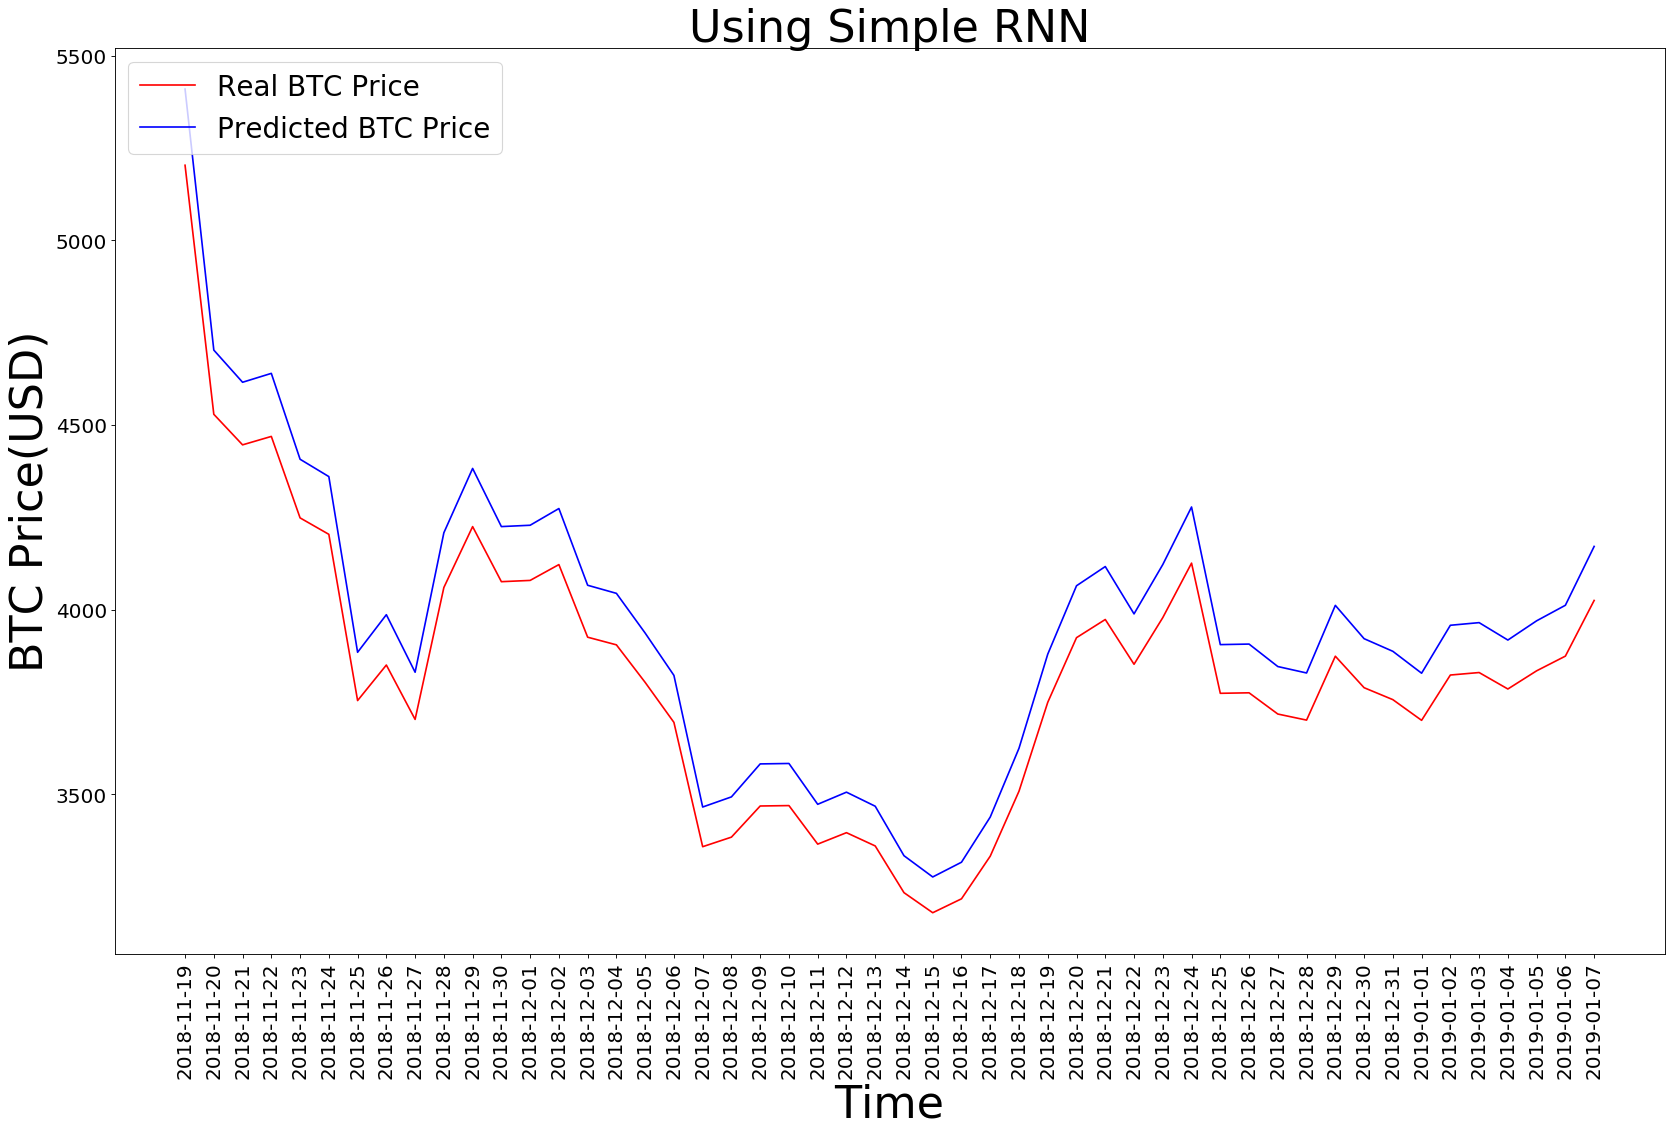

In [15]:
predicted_BTC_price = regressor4.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
er4 = np.mean((predicted_BTC_price-test_set)**2)
print("Mean Square Error (MSE) using RNN:", er4)
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('Using Simple RNN', fontsize=40)
# df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

* **Parameter tuning part:** In this section I am just experimenting with difference possible hyperparameters for the different models to select the best set. This section can be ignored once you have the best set of parameters.

In [16]:
# Initialising the RNN
regressor5 = Sequential()

# Adding the input layer and the LSTM layer
regressor5.add(GRU(units = 100, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor5.add(Dense(units = 1))

# Compiling the RNN
regressor5.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor5.fit(X_train, y_train, batch_size = 15, epochs = 50)

Epoch 1/50
1414/1414 [==============================] - 1s 929us/sample - loss: 0.0345
Epoch 2/50
1414/1414 [==============================] - 0s 329us/sample - loss: 0.0208
Epoch 3/50
1414/1414 [==============================] - 0s 315us/sample - loss: 0.0110
Epoch 4/50
1414/1414 [==============================] - 0s 332us/sample - loss: 0.0048
Epoch 5/50
1414/1414 [==============================] - 0s 314us/sample - loss: 0.0016
Epoch 6/50
1414/1414 [==============================] - 0s 333us/sample - loss: 4.9261e-04
Epoch 7/50
1414/1414 [==============================] - 0s 330us/sample - loss: 2.0651e-04
Epoch 8/50
1414/1414 [==============================] - 0s 326us/sample - loss: 1.5552e-04
Epoch 9/50
1414/1414 [==============================] - 0s 322us/sample - loss: 1.4611e-04
Epoch 10/50
1414/1414 [==============================] - 0s 326us/sample - loss: 1.5015e-04
Epoch 11/50
1414/1414 [==============================] - 0s 320us/sample - loss: 1.5320e-04
Epoch 12/50
1414/

Mean Square Error (MSE) using GRU2: 286446.8860490924


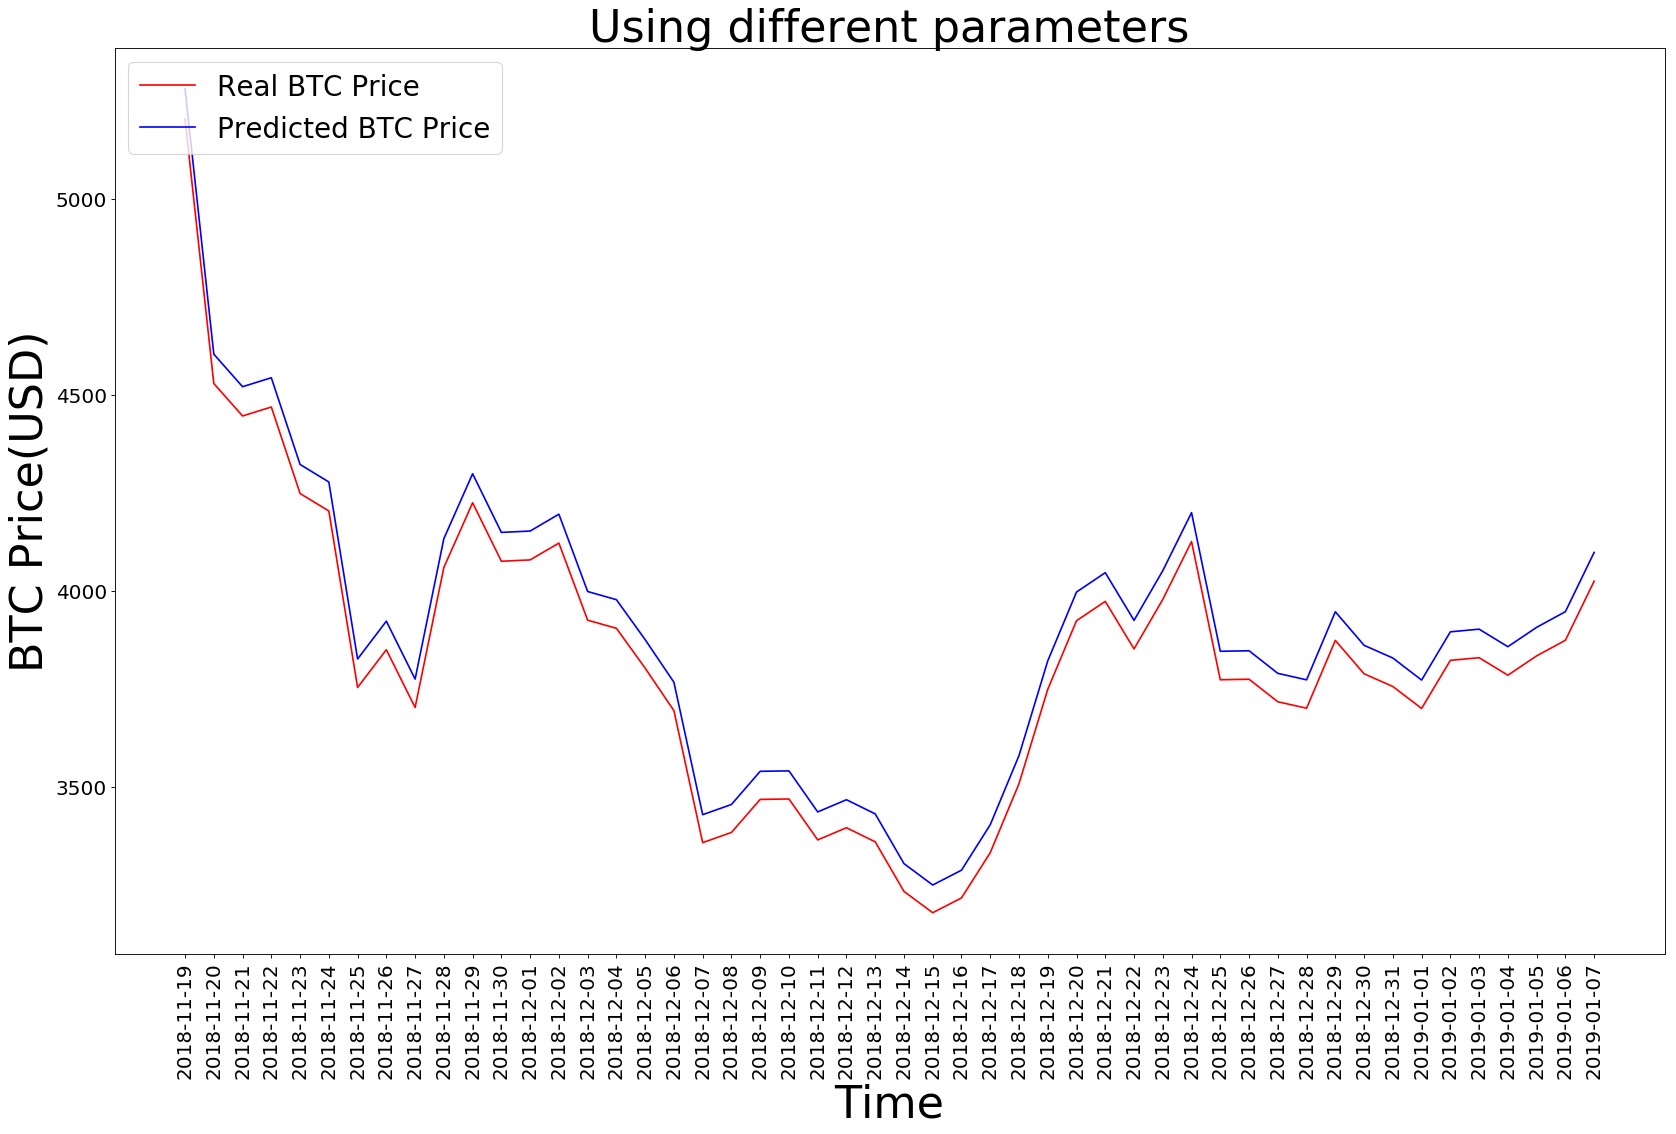

In [17]:
predicted_BTC_price = regressor5.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
er5 = np.mean((predicted_BTC_price-test_set)**2)
print("Mean Square Error (MSE) using GRU2:", er5)

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('Using different parameters', fontsize=40)
# df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [18]:
res = pd.DataFrame()
res['Model'] = ['Simple RNN', 'LSTM', 'GRU', 'CuDNNGRU']
res['Mean Square Error'] = [er4,er1,er2,er3]

print(res)

'''       Model  Mean Square Error
0  Simple RNN      315254.959201
1        LSTM      286786.010061
2         GRU      283144.297217
3    CuDNNGRU      281242.051223'''

''' We observe that Gated Recurrent Unit (backed by CUDNN) gives the least Mean Square Error loss this time. 
NOTE: The model behavior depends on the set of initial parameters, thus results may vary to certain extent'''

        Model  Mean Square Error
0  Simple RNN      314568.997874
1        LSTM      284947.222892
2         GRU      287069.878894
3    CuDNNGRU      285598.478758


' We observe that Gated Recurrent Unit (backed by CUDNN) gives the least Mean Square Error loss this time. \nNOTE: The model behavior depends on the set of initial parameters, thus results may vary to certain extent'

In [19]:
''' We save the trained model parameters so that it can be loaded and used in future'''
regressor.save('LSTM.hdf5')
regressor2.save('GRU.hdf5')
regressor3.save('CuDNNGRU.hdf5')
regressor4.save('RNN.hdf5')